In [9]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Imports

In [24]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time

In [3]:
dataset = pd.read_csv('training-a.csv')

In [4]:
labels = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
raw_data = dataset.drop(['label'],axis=1)

## Traitement

In [7]:
phases_list = ['S1','S2','systole','diastole']
features_list = ['t1','t2','t12','t21']

In [42]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)]) #on ignore les NaN 
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        E = -1*(E**2) * np.log(E**2)
        #on met les petites valeurs à 0 
        s = np.std(E)
        m = np.mean(E)
        mask = E>np.max(E)/3
        mask2 = E-m>s/2
        return E*mask
    
    def setStart(self,envelogram):
        #on s'assure de bien commencer sur une phase S1 ou S2
        start = 0
        while envelogram[start]==0:
            start += 1
        envelogram = envelogram [start:]
        return envelogram, start
    
    def consec_count(self):
        e = self.setStart(self.envelogram())[0]
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segment(self,count_vec,first_beat='S1',first_passive='systole'):
        beat_mask = count_vec<=100
        systole_mask = count_vec>100
        segmentation = []
        currentbeat = first_beat # etat courant du battement, soit S1 soit S2
        currentSD = first_passive # etat courant de la phase systole ou diastole
        i = 0
        while i<count_vec.shape[0]:
            while i<count_vec.shape[0] and beat_mask[i]:
                segmentation.append(currentbeat)
                i+=1
            #on change la phase de battement S1 ou S2 
            if currentbeat == 'S1':currentbeat='S2'
            else: currentbeat= 'S1'
            while i<count_vec.shape[0] and systole_mask[i]:
                segmentation.append(currentSD)
                i+=1
            #on change la phase systole ou diastole
            if currentSD == 'systole':currentSD='diastole'
            else: currentSD='systole'
        return np.array(segmentation)
    
    def checkSegmentation(self,segmentation):
        systole_length = np.sum(segmentation=='systole')
        diastole_length = np.sum(segmentation=='diastole')
        average_systole_length = systole_length/(systole_length+diastole_length)
        average_diastole_length = diastole_length/(systole_length+diastole_length)
        return (average_systole_length<average_diastole_length)
    
    def segmentation(self):
        count_vec = self.consec_count()
        #on teste une première segmentation
        seg = self.segment(count_vec)
        if self.checkSegmentation(seg):
            return seg
        else: 
            return self.segment(count_vec,first_beat='S2',first_passive='diastole')
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)
        return res[res!=0]
    
    def extractFeatures(self):
        segmentation = self.segmentation()
        features = {}
        for phase,ft in zip(phases_list,features_list):
            time_features = self.timeLengths(segmentation,phase)
            features.update({ft:[np.mean(time_features),np.min(time_features),
                                 np.max(time_features),np.std(time_features)]})
        return features
    

# Analyse des features

In [55]:
n_samples = 100

In [64]:
t1,t2,t12,t21=[],[],[],[]
for i in range(n_samples):
    pcg = PCG(raw_data.loc[i])
    ft = pcg.extractFeatures()
    t1.append(ft['t1'][3])
    t2.append(ft['t2'][3])
    t12.append(ft['t12'][3])
    t21.append(ft['t21'][3])

In [65]:
good = labels[:n_samples]==1
bad = labels[:n_samples]==-1

In [66]:
t1 = np.asarray(t1)
t2 = np.asarray(t2)
t12 = np.asarray(t12)
t21 = np.asarray(t21)

Text(0.5,1,'t21')

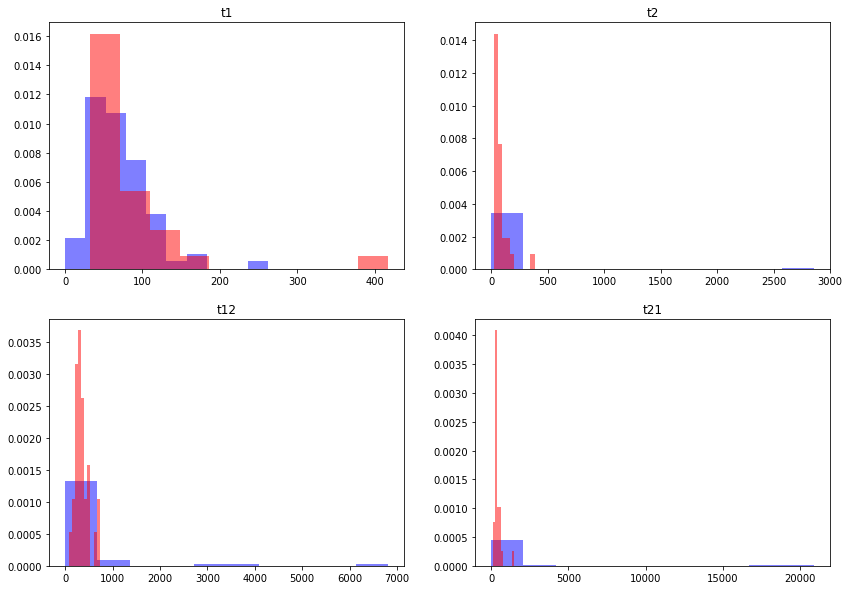

In [67]:
fig = plt.figure(figsize=(14,10))

ax1 = fig.add_subplot(221)
t = t
ax1.hist(t1[good],density=True,color='b',label='normal',alpha=.5)
t = t1[bad]
ax1.hist(t1[bad],density=True,color='r',label='anormal',alpha=.5)
ax1.set_title('t1')

ax2 = fig.add_subplot(222)
t = t2[good]
ax2.hist(t2[good],density=True,color='b',label='normal',alpha=.5)
t = t2[bad]
ax2.hist(t2[bad],density=True,color='r',label='anormal',alpha=.5)
ax2.set_title('t2')

ax3 = fig.add_subplot(223)
ax3.hist(t12[good],density=True,color='b',label='normal',alpha=.5)
ax3.hist(t12[bad],density=True,color='r',label='anormal',alpha=.5)
ax3.set_title('t12')

ax4 = fig.add_subplot(224)
ax4.hist(t21[good],density=True,color='b',label='normal',alpha=.5)
ax4.hist(t21[bad],density=True,color='r',label='anormal',alpha=.5)
ax4.set_title('t21')